In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

The Features API

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(x_train)
x_mean = scaler.mean_
x_std = scaler.scale_

In [3]:
import os
import pandas as pd

def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data('../datasets/housing/')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_median_age = tf.feature_column.numeric_column('housing_median_age')

In [6]:
age_mean, age_std = x_mean[1], x_std[1]
housing_median_age = tf.feature_column.numeric_column(
    'housing_median_age', normalizer_fn=lambda x: (x - age_mean) / age_std)

In [7]:
median_income = tf.feature_column.numeric_column('median_income')
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3, 4.5, 6])
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3, 4.5, 6))

In [8]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    'ocean_proximity', ocean_prox_vocab)
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [9]:
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    'city', hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [10]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1, -0.5, 0., 0.5, 1.])
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

In [11]:
latitude = tf.feature_column.numeric_column('latitude')
longitude = tf.feature_column.numeric_column('longitude')
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

In [12]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

In [13]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity, 
                                                           dimension=2)

In [14]:
median_house_value = tf.feature_column.numeric_column('median_house_value')

In [15]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [16]:
from tensorflow.train import FloatList, Features, Feature, Example

with tf.io.TFRecordWriter('my_data_with_features.tfrecord') as f:
    for x, y in zip(x_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            'housing_median_age': Feature(float_list=FloatList(value=[x])),
            'median_house_value': Feature(float_list=FloatList(value=[y])),
        }))
        f.write(example.SerializeToString())

In [17]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop('median_house_value')
    return examples, targets

In [18]:
batch_size = 32
dataset = tf.data.TFRecordDataset(['my_data_with_features.tfrecord'])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

In [19]:
columns_without_target = columns[:-1]

model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])

model.compile(loss='mse', 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3), 
              metrics=['acc'])

model.fit(dataset, steps_per_epoch=len(x_train) // batch_size, epochs=5)

Epoch 1/5
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
362/362 [==============================] - 0s 573us/step - loss: 4.8348 - acc: 0.0013
Epoch 2/5
362/362 [==============================] - 0s 571us/step - loss: 2.1667 - acc: 0.0018
Epoch 3/5
362/362 [==============================] - 0s 571us/step - loss: 1.5194 - acc: 0.0035
Epoch 4/5
362/362 [==============================] - 0s 571us/step - loss: 1.3778 - acc: 0.0031
Epoch 5/5
362/362 [==============================] - 0s 565us/step - loss: 1.3534 - acc: 0.0025


In [20]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    'ocean_proximity': [['NEAR OCEAN'], ['INLAND'], ['INLAND']],
    'median_income': [[3.], [7.2], [1.]],
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.670503  , -0.20848627],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -0.46782884,  1.3909093 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.46782884,  1.3909093 ]], dtype=float32)>

TF Transform

In [21]:
try:
    import tensorflow_transform as tft
    
    def preprocess(inputs):
        median_age = inputs['housing_median_age']
        ocean_proximity = inputs['ocean_proximity']
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            'standardized_median_age': standardized_age,
            'ocean_proximity_id': ocean_proximity_id,
        }
except ImportError:
    print('TF Transform is not installed, Try running: pip install -U tensorflow-transform')

TensorFlow Datasets

In [22]:
try:
    import tensorflow_datasets as tfds
    
    datasets = tfds.load(name='mnist')
    mnist_train, mnist_test = datasets['train'], datasets['test']
except ImportError:
    print('TFDS is not installed, Try running: pip install -U tensorflow-datasets')

In [23]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'bccd', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'd4rl_adroit_door', 'd4rl_adroit_hammer', 'd4rl_adroit_pen', 'd4rl_adroit_relocate', 'd4rl_mujoco_ant', 'd4rl_mujoco_halfcheetah', 'd4rl_mujoco_hopper', 'd4rl_mujoco_walk

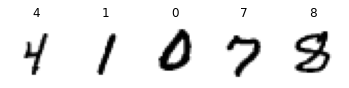

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)

for item in mnist_train:
    images = item['image']
    labels = item['label']
    for idx in range(5):
        plt.subplot(1, 5, idx + 1)
        image = images[idx, ..., 0]
        label = labels[idx].numpy()
        plt.imshow(image, cmap='binary')
        plt.title(label)
        plt.axis('off')
    break

In [25]:
datasets = tfds.load(name='mnist')
mnist_train, mnist_test = datasets['train'], datasets['test']
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items['image'], item['label']))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [26]:
datasets = tfds.load(name='mnist', batch_size=32, as_supervised=True)
mnist_train = datasets['train'].repeat().prefetch(1)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3), 
              metrics=['acc'])

model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 700us/step - loss: 31.8555 - acc: 0.8440
Epoch 2/5
1875/1875 [==============================] - 1s 665us/step - loss: 26.3087 - acc: 0.8678
Epoch 3/5
1875/1875 [==============================] - 1s 611us/step - loss: 24.7863 - acc: 0.8737
Epoch 4/5
1875/1875 [==============================] - 1s 602us/step - loss: 24.5841 - acc: 0.8747
Epoch 5/5
1875/1875 [==============================] - 1s 641us/step - loss: 24.1287 - acc: 0.8781


TensorFlow Hub

In [27]:
try:
    import tensorflow_hub as hub
    
except ImportError:
    print('tensorflow-hub is not installed, Try running: pip install -U tensorflow-hub')

In [28]:
hub_layer = hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1', 
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential([
    hub_layer,
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [29]:
sentences = tf.constant(['It was a great movie', 'The actors were amazing'])
embeddings = hub_layer(sentences)

In [30]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       